In [5]:
%load_ext autoreload
%autoreload 2

import seaborn # icefire 
import numpy as np
import scipy
import scipy.integrate
import scipy.sparse
import matplotlib.pyplot as plt

# package settings
np.random.seed(42)
plt.style.use('dark_background')
plt.rcParams.update({'font.size': 20})

import perc
from perc.utils import unflatten_scalar_data, unflatten_vel_data, flatten_vel_data
import perc.vis as vis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Constants

In [6]:
### Data Constants
DT = 0.01
DOWNSAMPLE_FACTOR = 10 # downsample data in time
DT = DT * DOWNSAMPLE_FACTOR # update dt if downsampling
DOMAIN = (0, 1.0)
GRID_SIZE = 32
TEST_PERC = 0.05 
TN = 100 # make sure ./data contains the proper file 
DATA_DIR = "../data/kol_flow/"

### RC Configuration
base_config = {
    "Nu": GRID_SIZE**2*2,
    "Nr": 20000,
    "alpha": 0.6,
    "beta": 1e-7,
    "rho_A": 0.01,
    "lambda_max": 0.8,
    "sigma": 0.088,
    "bias": 1.6,
    "spinup": 0
}

# Load data 

U shape: (2048, 1000)
t shape: (1000,)
U_train shape: (2048, 800)
U_test shape: (2048, 200)


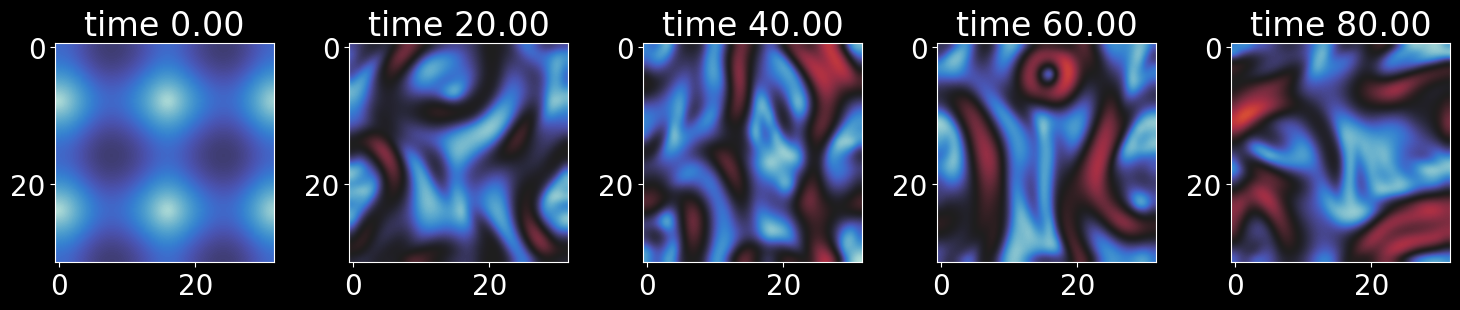

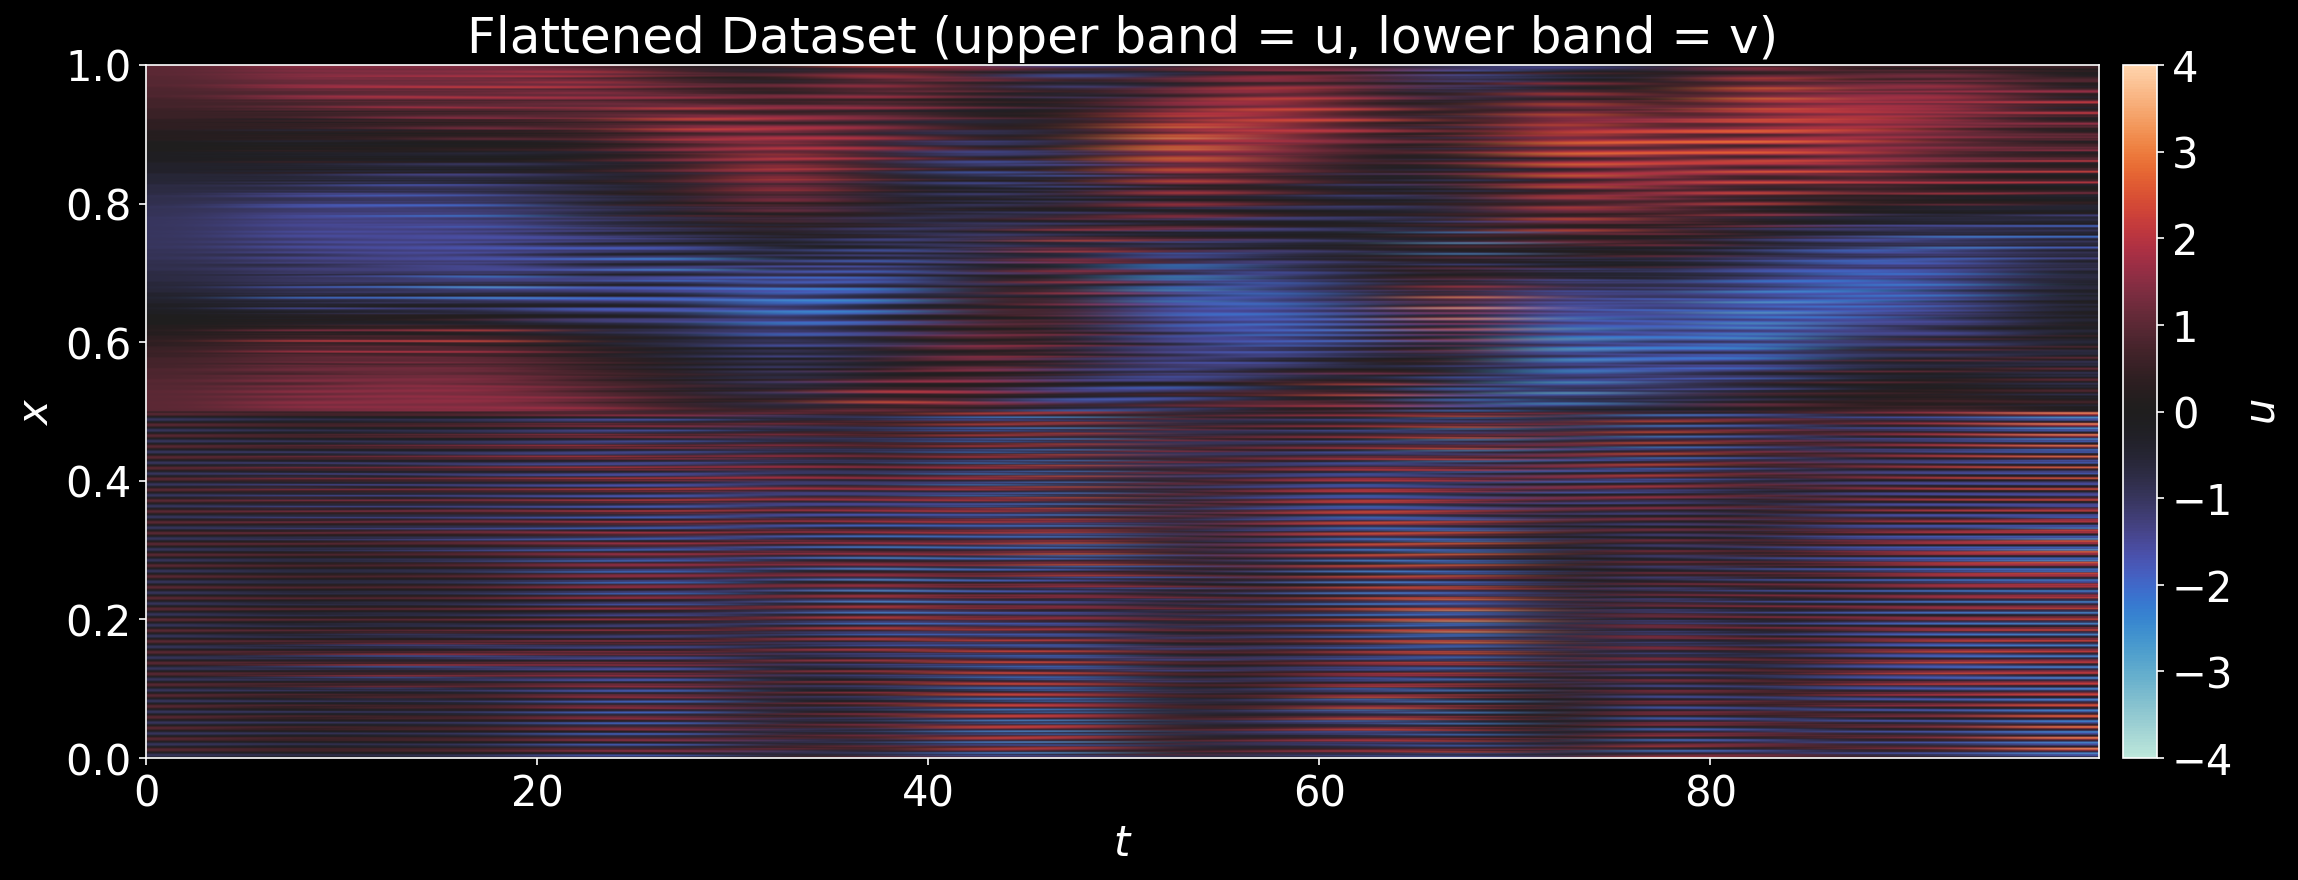

In [7]:
### Get Data - Incompressible Kolmogorov Flow downsampled to 2 x ds x ds ###

# load in data
U = flatten_vel_data(np.load(DATA_DIR + 'kol_flow_velocity_{}x{}_RE500_dt_{}_tf_{}.npy'.format(GRID_SIZE, GRID_SIZE, DT/DOWNSAMPLE_FACTOR, TN))).T
U = U[:, ::DOWNSAMPLE_FACTOR] # downsample in time
t = np.arange(0, DT*U.shape[1], DT)

# split data
test_split = 0.2 #percentage of dset for testing
split_idx = int((1-test_split) * U.shape[1])
U_train = U[:, :split_idx]
t_train = t[:split_idx]
U_test = U[:, split_idx:]
t_test = np.linspace(0, U_test.shape[1]*DT, U_test.shape[1]) 

# print data info and plot
print('U shape:', U.shape)
print('t shape:', t.shape)
print('U_train shape:', U_train.shape)
print('U_test shape:', U_test.shape)
vis.plot_vel_data(
    U.T,
    DT, 
    num_cols=5,
    interpolation="bicubic",
    cmap="icefire",
    vmin=0,
    vmax=4.0,
)
vis.imshow_1D_spatiotemp(
    U[:, ::50],
    t[-1],
    DOMAIN,
    title='Flattened Dataset (upper band = u, lower band = v)',
    vmin=-4,
    vmax=4,
    cmap='icefire',
)

# Define Constraints

In [8]:
def create_divergence_stencil(Nu):
    '''
    Create divergence stencil for divergence constraint. The divergence stencil is a sparse matrix that can be used to calculate the divergence of a 2D velocity field.

    INPUTS:
        Nu: number of spatial points in the velocity field (N**2)
    
    OUTPUTS:
        Div: divergence stencil sparse matrix of shape (Nu, 2*Nu) so that Div @ U_flat = divergence(U)
    '''

    # Build divergence constraint matricies
    M = Nu//2 # number of spatial points (u and v for each spatial point)
    N = int(np.sqrt(M)) # length of each side of the spatial grid
    h = 1 # h = dx = dy (doesn't matter for purpose of optimization)

    # x derivative
    Dx = scipy.sparse.diags([-1,0, 1], [-N,0,N], shape=(M,M), format = 'dok')
    # Apply periodic boundary conditions
    for i in range(N):
        # Top side
        Dx[i, i+N*(N-1)] = -1

        #Bottom side
        Dx[M-N + i, i] = 1
    Dx = 1/(2*h)*Dx
    Dx = scipy.sparse.csr_matrix(Dx)

    # y derivative
    Dy = scipy.sparse.diags([-1,0, 1], [-1,0,1], shape=(M,M), format = 'dok')
    #Apply periodic boundary conditions
    for i in range(N-1):
        #left side
        Dy[(i+1)*N, (i+1)*N-1] = 0
        Dy[(i+1)*N, (i+1)*N+N-1] = -1

        #right side
        Dy[(i+1)*N-1, (i+1)*N] = 0
        Dy[(i+1)*N-1, (i+1)*N-N] = 1
    Dy[0, N-1] = -1
    Dy[M-1, M-N] = 1
    Dy = 1/(2*h)*Dy
    Dy = scipy.sparse.csr_matrix(Dy)

    # create single divergence stencil
    Div = scipy.sparse.hstack([Dx, Dy])
    return Div

def get_div_ts(U, Div):
    '''Get the divergence at each time step for a given velocity field U.'''
    return np.array([Div.dot(U[:, i]) for i in range(U.shape[1])])

In [9]:
# create divergence stencil
Div = create_divergence_stencil(base_config['Nu'])
print('Divergence stencil shape:', Div.shape)

Divergence stencil shape: (1024, 2048)


# Train Unconstrained RC

Training ...
Forecasting ...
Constraint Error (RC training): 14.152749791024812
Constraint Error (RC forecast): 9.591804067078344


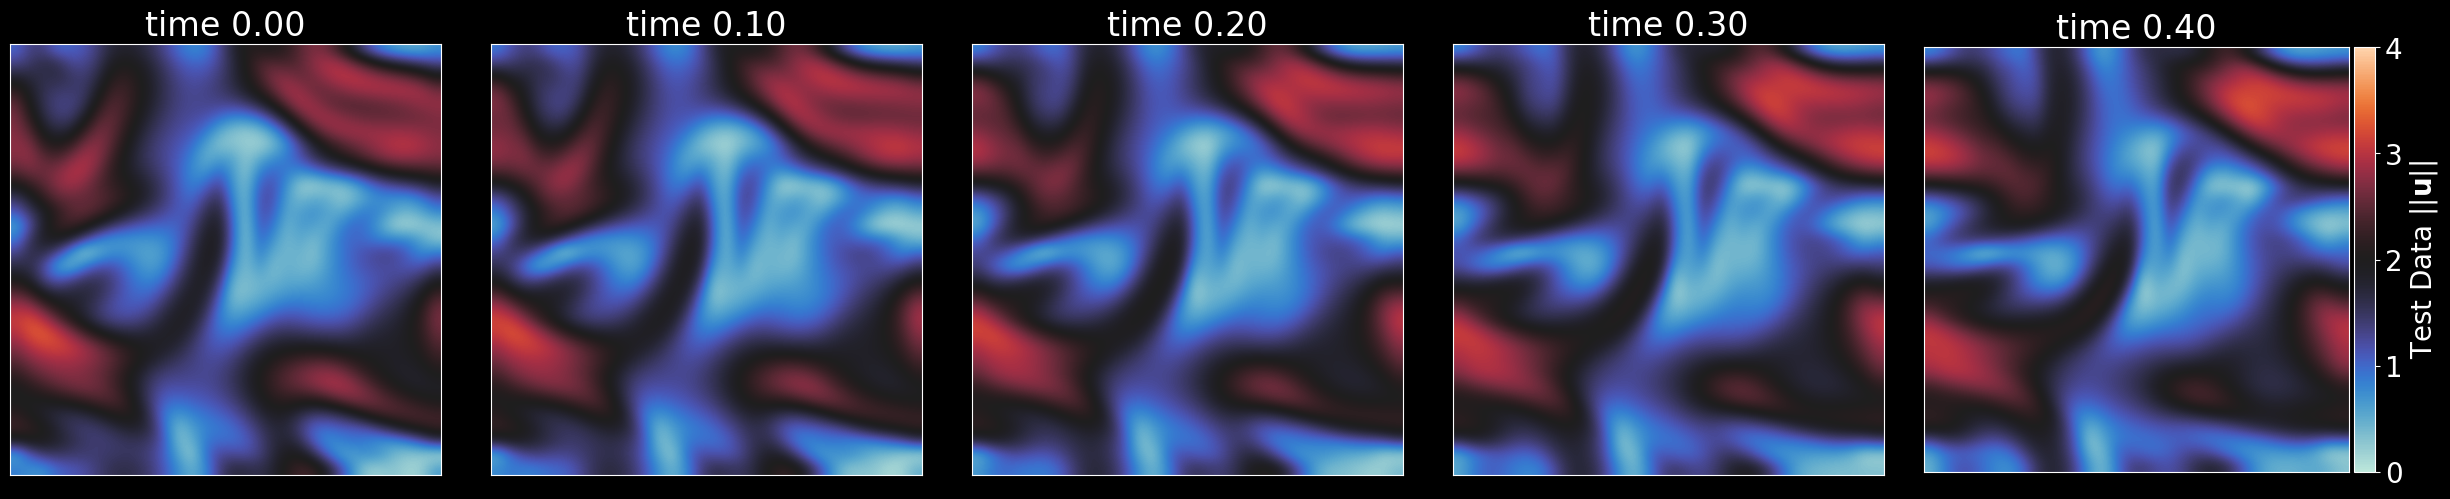

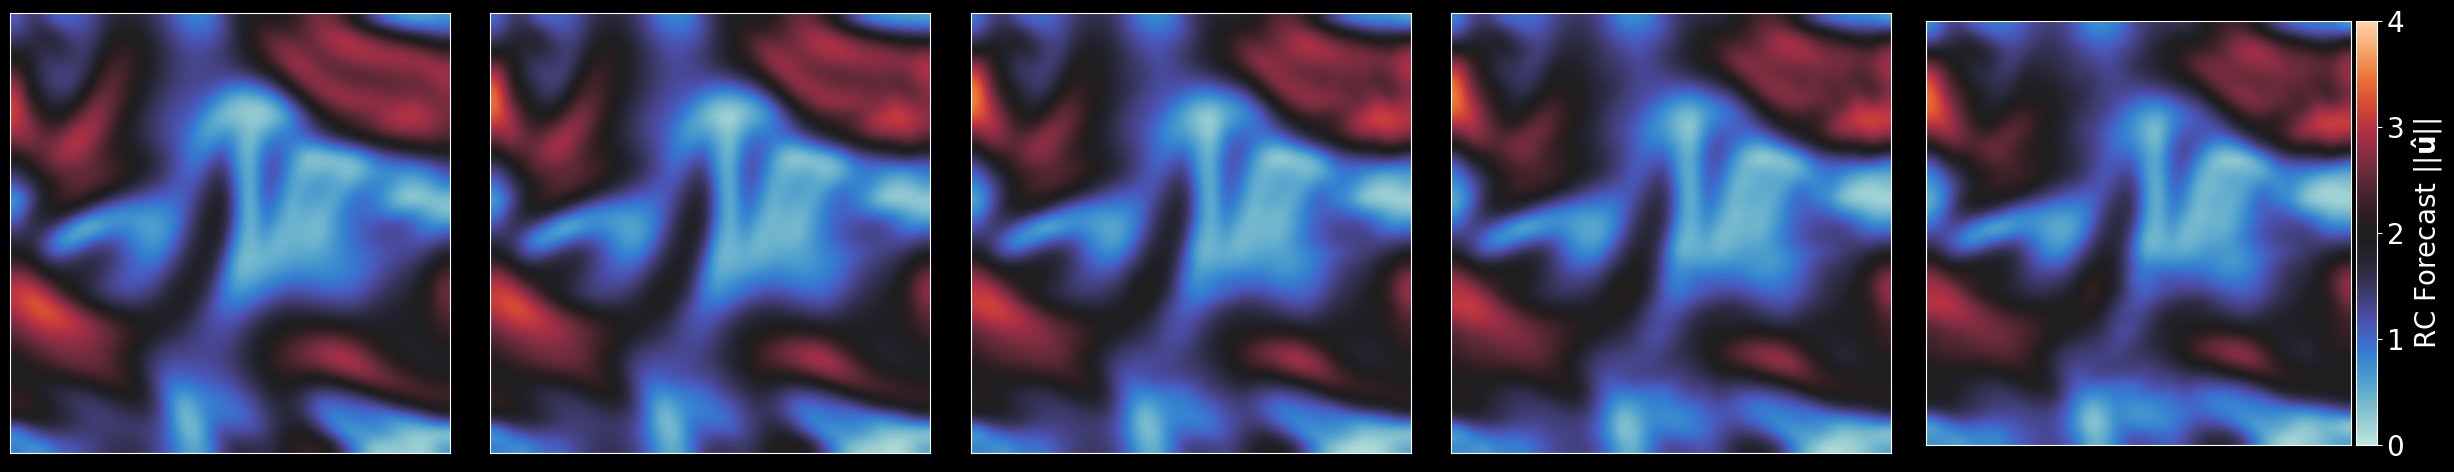

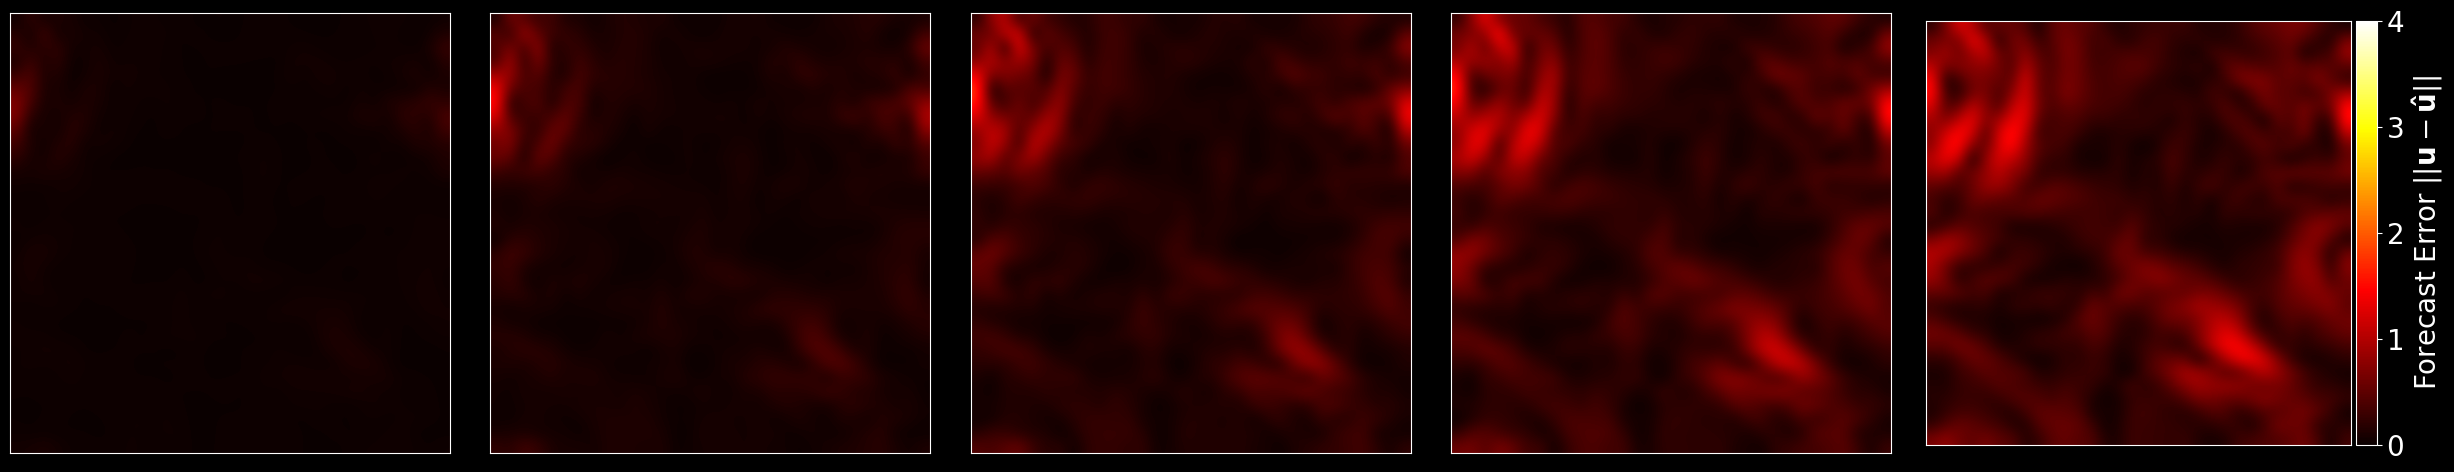

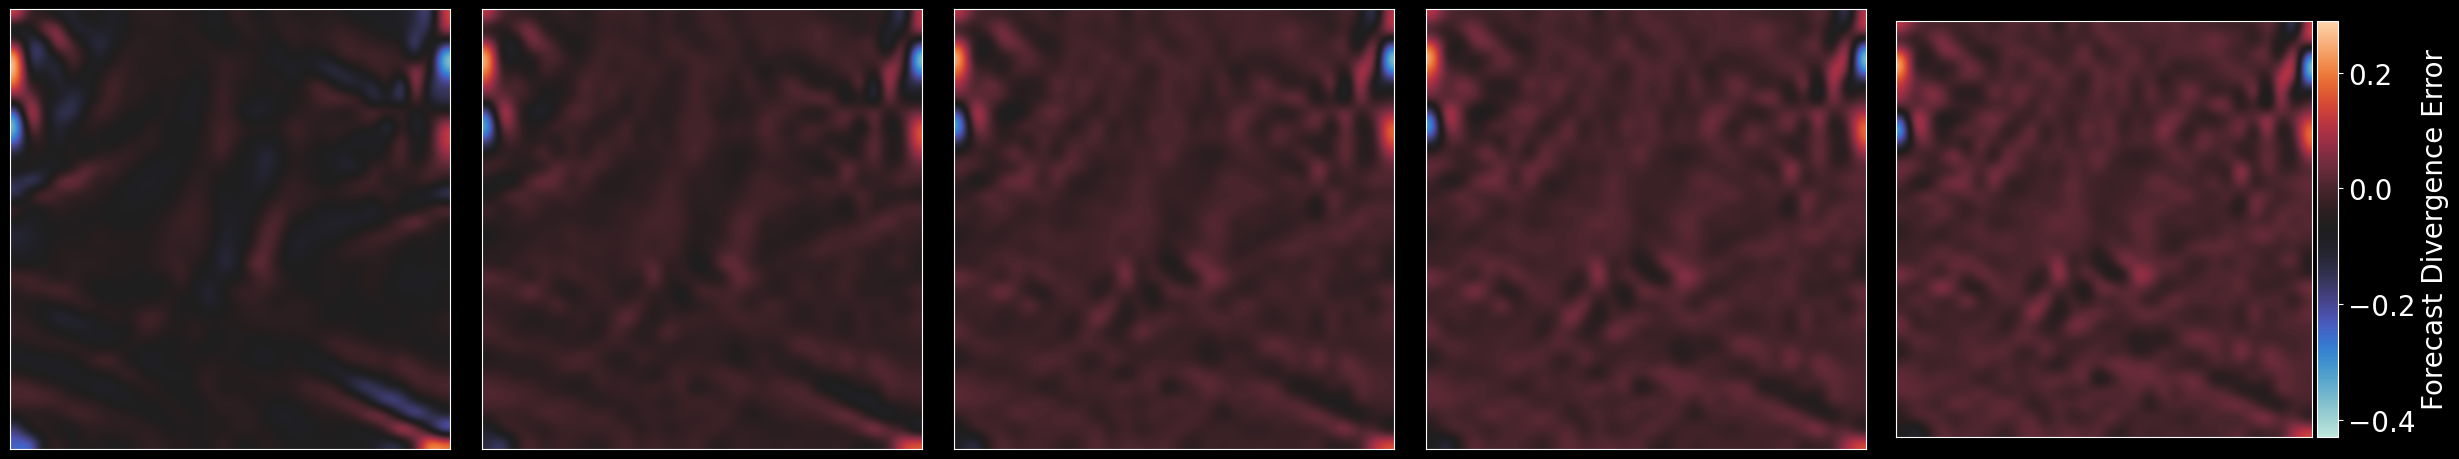

In [10]:
### Train Unconstrained RC ###
print('Training ...')
RC_uc = perc.ReservoirComputer(**base_config)
R = RC_uc.train(U_train)
U_pred_train_uc = RC_uc.W_out @ R #training results

# Forecast
print('Forecasting ...')
n = U_test.shape[1]
U_pred_test_uc = RC_uc.forecast(n)

# Print constraint check
print('Constraint Error (RC training):', np.linalg.norm(get_div_ts(U_pred_train_uc, Div)))
print('Constraint Error (RC forecast):', np.linalg.norm(get_div_ts(U_pred_test_uc, Div)))

# Plot
n = 5  
U_test_plot = np.linalg.norm(unflatten_vel_data(U_test.T[:n, :]), axis = 1)
U_pred_test_plot = np.linalg.norm(unflatten_vel_data(U_pred_test_uc.T[:n, :]), axis = 1)
err = np.abs(U_pred_test_uc - U_test)
err_plot = np.linalg.norm(unflatten_vel_data(err.T[:n, :]), axis = 1)
div_err = get_div_ts(U_pred_test_uc, Div)[:n]
div_err_plot = unflatten_scalar_data(div_err)
vis.plot_scalar_row(U_test_plot, DT, r"Test Data $||\mathbf{u}||$", interpolation = "bicubic", cmap = "icefire", vmin = 0, vmax = 4.0, show_title=True)
vis.plot_scalar_row(U_pred_test_plot, DT, r"RC Forecast $||\mathbf{\hat{u}}||$", interpolation = "bicubic", cmap = "icefire", vmin = 0, vmax = 4.0)
vis.plot_scalar_row(err_plot, DT, r"Forecast Error $||\mathbf{u} - \mathbf{\hat{u}}||$", interpolation = "bicubic", cmap = 'hot', vmin = 0, vmax = 4.0)
vis.plot_scalar_row(div_err_plot, DT, r"Forecast Divergence Error", interpolation = "bicubic", cmap = 'icefire')

# Train Constrained RC

Training ...
Forecasting ...
Constraint Error (RC training): 1.0069909250526442e-12
Constraint Error (RC forecast): 1.2077267582207543e-12


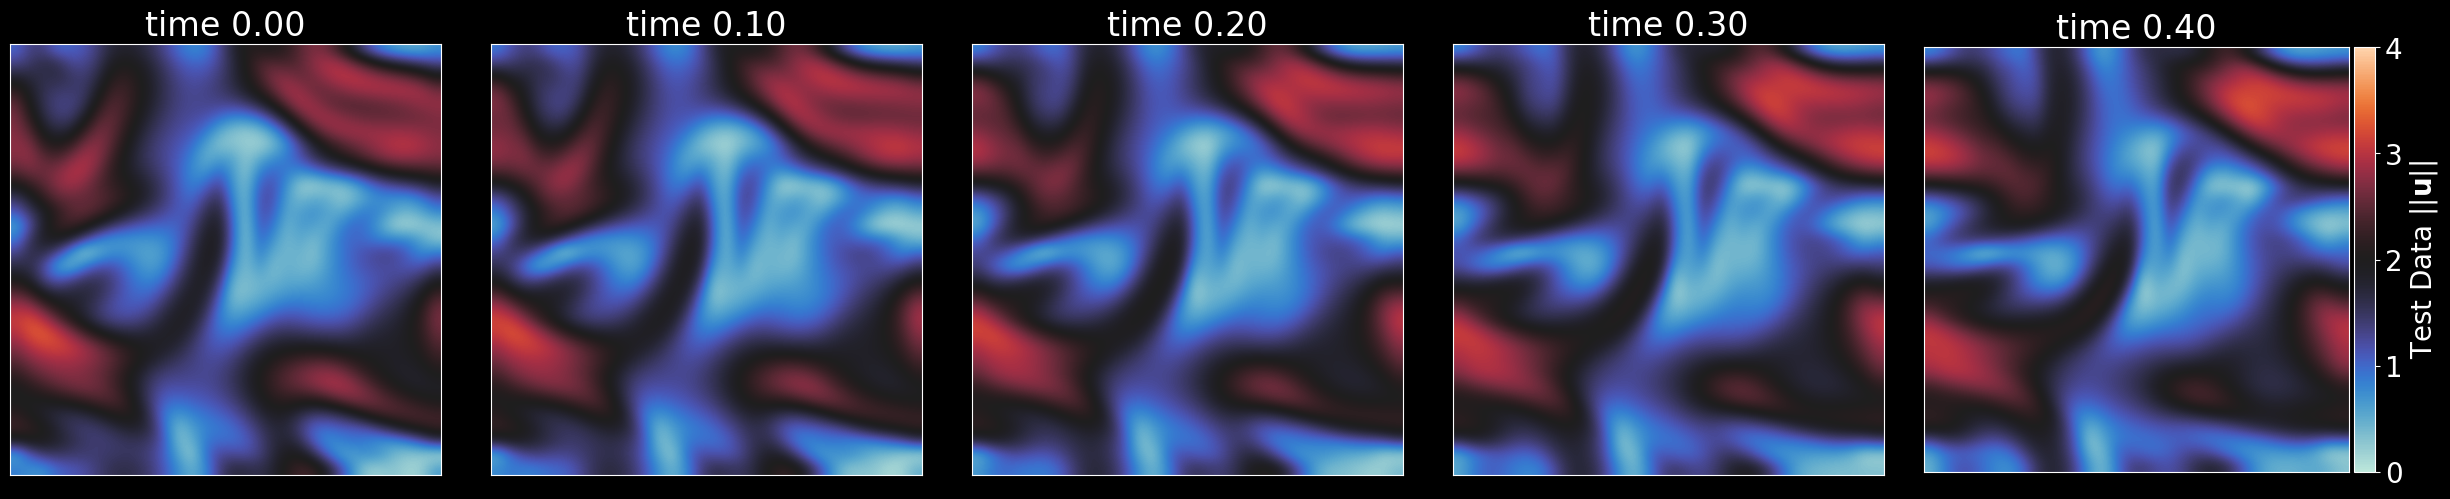

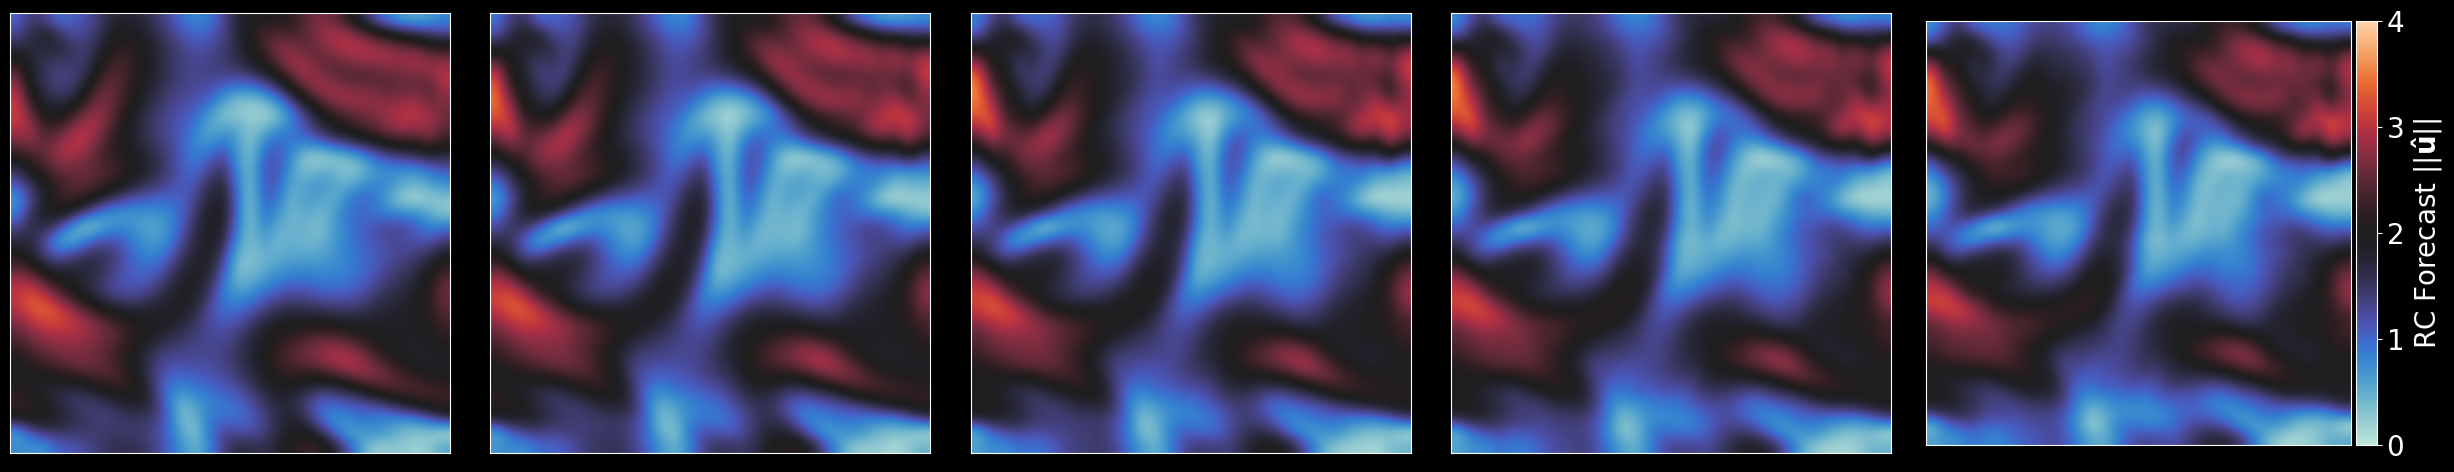

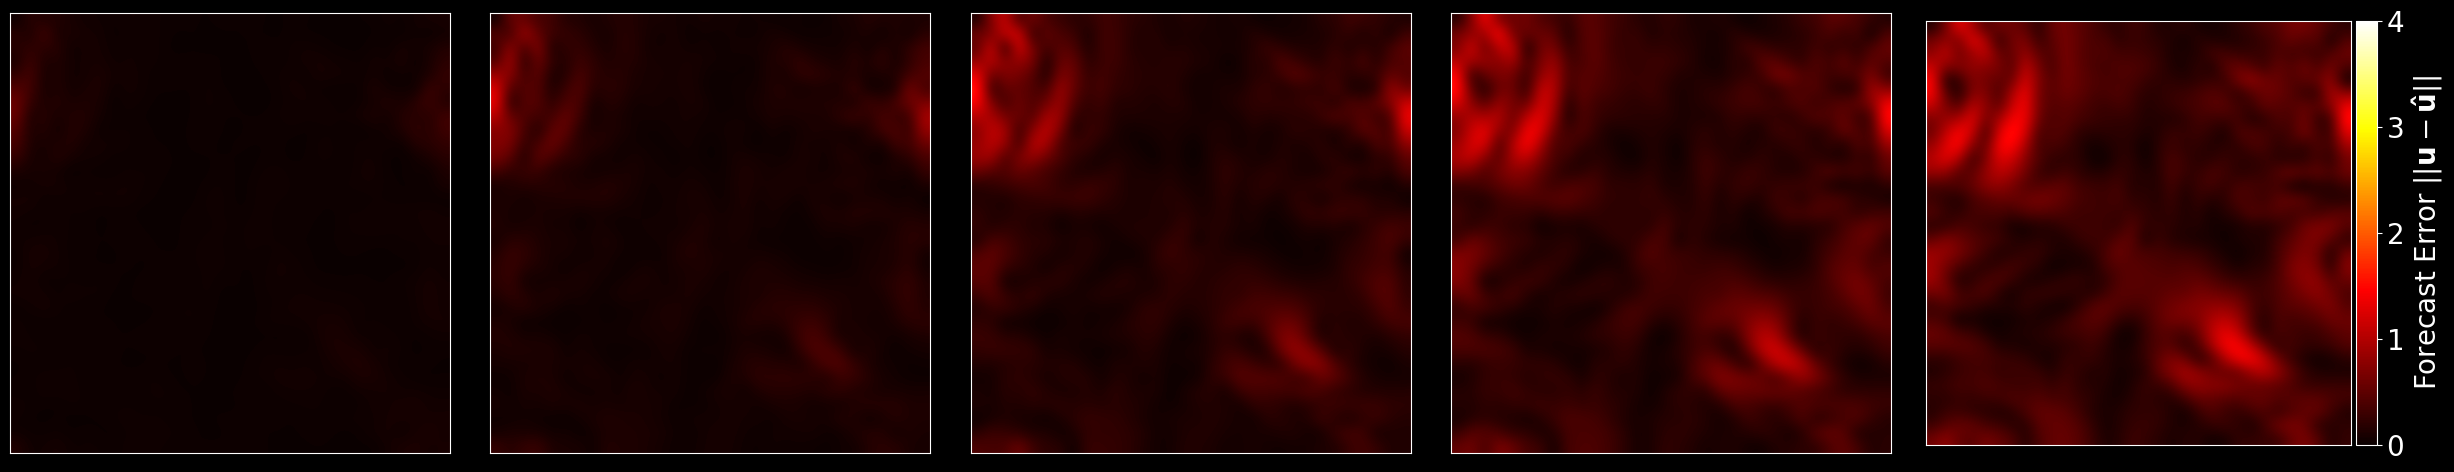

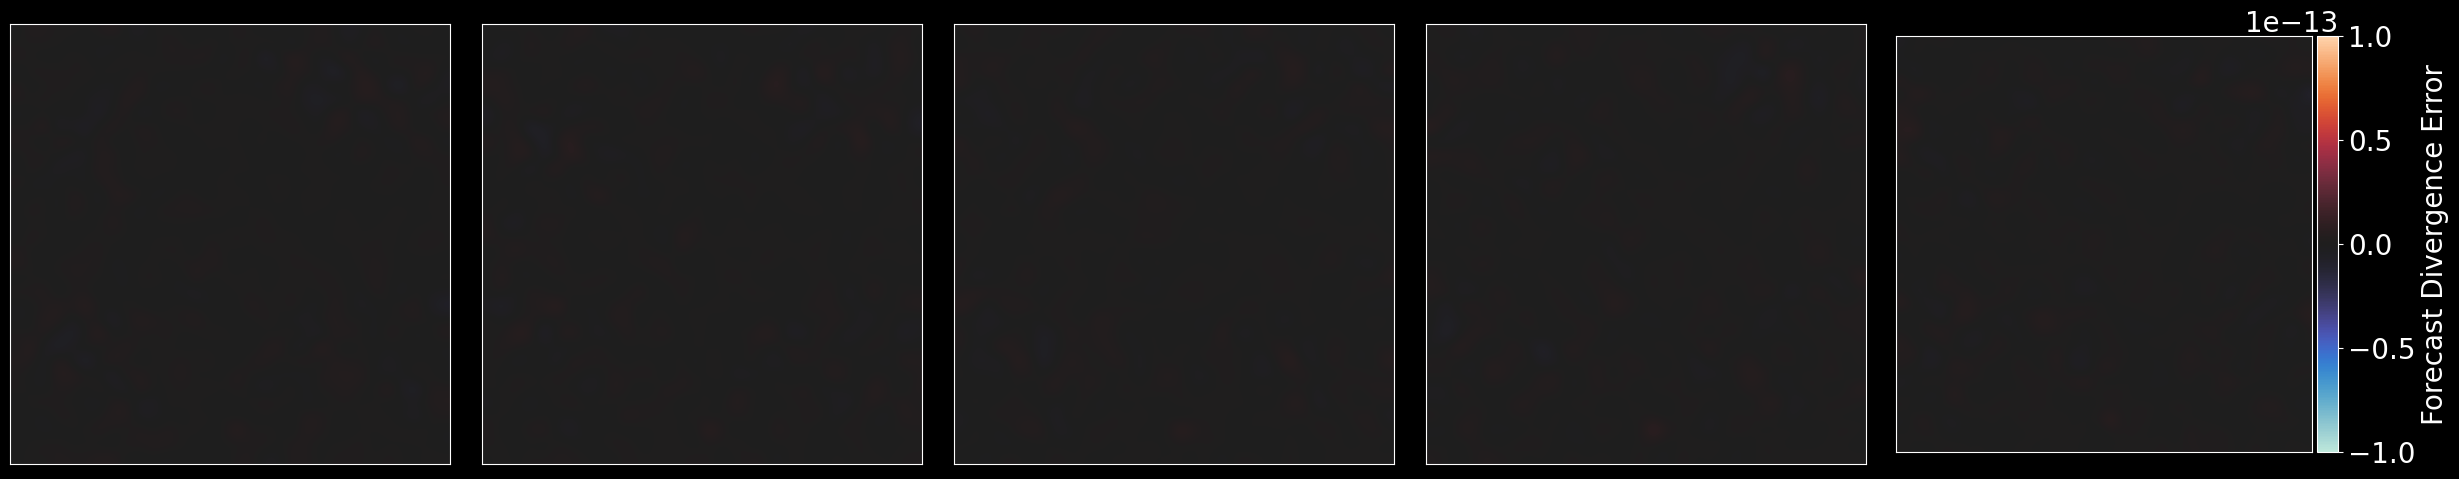

In [11]:
### Train Unconstrained RC ###
print('Training ...')
RC_c = perc.ReservoirComputer(**base_config)
R = RC_c.train_lh(U_train, C=Div.todense())
U_pred_train_c = RC_c.W_out @ R #training results

# Forecast
print('Forecasting ...')
n = U_test.shape[1]
U_pred_test_c = RC_c.forecast(n)

# Print constraint check
print('Constraint Error (RC training):', np.linalg.norm(get_div_ts(U_pred_train_c, Div)))
print('Constraint Error (RC forecast):', np.linalg.norm(get_div_ts(U_pred_test_c, Div)))

# Plot
n = 5  
U_test_plot = np.linalg.norm(unflatten_vel_data(U_test.T[:n, :]), axis = 1)
U_pred_test_plot = np.linalg.norm(unflatten_vel_data(U_pred_test_c.T[:n, :]), axis = 1)
err = np.abs(U_pred_test_c - U_test)
err_plot = np.linalg.norm(unflatten_vel_data(err.T[:n, :]), axis = 1)
div_err = get_div_ts(U_pred_test_c, Div)[:n]
div_err_plot = unflatten_scalar_data(div_err)
vis.plot_scalar_row(U_test_plot, DT, r"Test Data $||\mathbf{u}||$", interpolation = "bicubic", cmap = "icefire", vmin = 0, vmax = 4.0, show_title=True)
vis.plot_scalar_row(U_pred_test_plot, DT, r"RC Forecast $||\mathbf{\hat{u}}||$", interpolation = "bicubic", cmap = "icefire", vmin = 0, vmax = 4.0)
vis.plot_scalar_row(err_plot, DT, r"Forecast Error $||\mathbf{u} - \mathbf{\hat{u}}||$", interpolation = "bicubic", cmap = 'hot', vmin = 0, vmax = 4.0)
vis.plot_scalar_row(div_err_plot, DT, r"Forecast Divergence Error", interpolation = "bicubic", cmap = 'icefire', vmin = -1e-13, vmax = 1e-13)